# MVP analysis
#### This is a simple analysis from a small dataset on the MVPs for a few different basketball leagues (mainly the NBA as we will see in a bit)

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col ,concat, lit , isnan, when, count, mean, min, max
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import six
from scipy import stats
import numpy as np
import pandas as pd

# Importing the dataset

In [0]:
df = spark.read.csv( "/FileStore/tables/MVP_Basket.csv" , inferSchema = True, header = True , sep="," )
display(df.head(5))

Season,Player,Team,Lg,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%
2018-19,Andrew Bogut\andrew-bogut-1,Sydney,NBL Australia�au,28,29.2,11.6,11.6,3.4,0.6,2.7,0.569,0,0.6
2018-19,Luke Sikma\luke-sikma-1,ALBA Berlin,EuroCup�eu,24,27.0,11.3,6.6,4.2,1.5,0.5,0.482,0.389,0.769
2018-19,Jan Vesely\jan-vesely-1,Fenerbahce,EuroLeague�eu,31,25.1,12.3,4.7,2.4,1.4,0.5,0.651,0.2,0.787
2018-19,David Holston\david-holston-1,Dijon,LNB Pro A�fr,33,29.1,14.2,2.5,7.2,1.6,0,0.464,0.412,0.849
2018-19,Drew Crawford\drew-crawford-1,Vanoli Cremona,Lega Serie A�it,25,31.5,17.8,4.4,2.0,0.8,0.3,0.505,0.37,0.763


## Exploring the Dataframe before clean up

In [0]:
# With printSchema() we can see the list of columns along with their data types.
df.printSchema()

root
 |-- Season: string (nullable = true)
 |-- Player: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Lg: string (nullable = true)
 |-- G: integer (nullable = true)
 |-- MP: double (nullable = true)
 |-- PTS: double (nullable = true)
 |-- TRB: double (nullable = true)
 |-- AST: double (nullable = true)
 |-- STL: string (nullable = true)
 |-- BLK: string (nullable = true)
 |-- FG%: double (nullable = true)
 |-- 3P%: string (nullable = true)
 |-- FT%: double (nullable = true)



In [0]:
print((df.count(), len(df.columns)))

(183, 14)


# Clean up 
### We can see that the dataset has some confusing column names, as well as some strange naming in the league column.

We can start cleaning up the names on the league column through a simple function

In [0]:
def clean_text(c):
  c = F.regexp_replace(c, "�eu", "")
  c = F.regexp_replace(c, "�au", "")
  c = F.regexp_replace(c, "�es", "")
  c = F.regexp_replace(c, "�it", "")
  c = F.regexp_replace(c, "�fr", "")
  c = F.regexp_replace(c, "�gr", "")
  c = F.regexp_replace(c, "�fr", "")
  return c

In [0]:
columns = ["Player","Team",clean_text("Lg").alias("League"),"G","MP","PTS","TRB","AST","3P%", "FG%","FT%","STL","BLK"]

df_1 = df.select(columns)

In [0]:
display(df_1.head(5))

Player,Team,League,G,MP,PTS,TRB,AST,3P%,FG%,FT%,STL,BLK
Andrew Bogut\andrew-bogut-1,Sydney,NBL Australia,28,29.2,11.6,11.6,3.4,0,0.569,0.6,0.6,2.7
Luke Sikma\luke-sikma-1,ALBA Berlin,EuroCup,24,27.0,11.3,6.6,4.2,0.389,0.482,0.769,1.5,0.5
Jan Vesely\jan-vesely-1,Fenerbahce,EuroLeague,31,25.1,12.3,4.7,2.4,0.2,0.651,0.787,1.4,0.5
David Holston\david-holston-1,Dijon,LNB Pro A,33,29.1,14.2,2.5,7.2,0.412,0.464,0.849,1.6,0
Drew Crawford\drew-crawford-1,Vanoli Cremona,Lega Serie A,25,31.5,17.8,4.4,2.0,0.37,0.505,0.763,0.8,0.3


## We can now rename the columns to read the data more easily

In [0]:
df_2 = df_1.select(
                df_1.Player,
                df_1.Team,
                df_1.League,
                df_1.G.alias("Games_played"),
                df_1.MP.alias("Mins_per_game"),
                df_1.PTS.alias("Points_per_game"),
                df_1.TRB.alias("Rebounds_per_game"),
                df_1.AST.alias("Assists_per_game"),
                df_1["3P%"].alias("Three_point").cast("double"),
                df_1["FG%"] ,
                df_1["FT%"] ,
                df_1.STL.alias("Steals_per_game").cast("double"),
                df_1.BLK.alias("Blocks_per_game").cast("double"))

In [0]:
display(df_2.head(5))

Player,Team,League,Games_played,Mins_per_game,Points_per_game,Rebounds_per_game,Assists_per_game,Three_point,FG%,FT%,Steals_per_game,Blocks_per_game
Andrew Bogut\andrew-bogut-1,Sydney,NBL Australia,28,29.2,11.6,11.6,3.4,0.0,0.569,0.6,0.6,2.7
Luke Sikma\luke-sikma-1,ALBA Berlin,EuroCup,24,27.0,11.3,6.6,4.2,0.389,0.482,0.769,1.5,0.5
Jan Vesely\jan-vesely-1,Fenerbahce,EuroLeague,31,25.1,12.3,4.7,2.4,0.2,0.651,0.787,1.4,0.5
David Holston\david-holston-1,Dijon,LNB Pro A,33,29.1,14.2,2.5,7.2,0.412,0.464,0.849,1.6,0.0
Drew Crawford\drew-crawford-1,Vanoli Cremona,Lega Serie A,25,31.5,17.8,4.4,2.0,0.37,0.505,0.763,0.8,0.3


# Null Values: check and replace null values

In [0]:
display(  df_2.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_2.columns])   )

Player,Team,League,Games_played,Mins_per_game,Points_per_game,Rebounds_per_game,Assists_per_game,Three_point,FG%,FT%,Steals_per_game,Blocks_per_game
0,0,0,0,0,0,0,0,26,0,0,18,18


We can see that the dataset only has null values in two columns: Steals per game and blocks per game, so we only need to address those two columns instead of the whole dataset.

In [0]:
df_3 = df_2.na.fill({'Steals_per_game': 0})
df_3 = df_3.na.fill({'Blocks_per_game': 0})
df_3 = df_3.na.fill({'Three_point': 0})

In [0]:
display(df_3.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_3.columns]))

Player,Team,League,Games_played,Mins_per_game,Points_per_game,Rebounds_per_game,Assists_per_game,Three_point,FG%,FT%,Steals_per_game,Blocks_per_game
0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
display(df_3.tail(5))

Player,Team,League,Games_played,Mins_per_game,Points_per_game,Rebounds_per_game,Assists_per_game,Three_point,FG%,FT%,Steals_per_game,Blocks_per_game
Wilt Chamberlain\chambwi01,PHW,NBA,72,46.4,37.6,27.0,2.3,0.0,0.461,0.582,0.0,0.0
Bob Pettit\pettibo01,STL,NBA,72,39.9,29.2,16.4,3.1,0.0,0.438,0.759,0.0,0.0
Bill Russell\russebi01,BOS,NBA,69,38.3,16.6,22.7,2.9,0.0,0.442,0.519,0.0,0.0
Bob Cousy\cousybo01,BOS,NBA,64,36.9,20.6,4.8,7.5,0.0,0.378,0.821,0.0,0.0
Bob Pettit\pettibo01,STL,NBA,72,38.8,25.7,16.2,2.6,0.0,0.429,0.736,0.0,0.0


#### We can now view the statistical summary of the dataset through the .describe() .toPandas() function

In [0]:
df_3.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Player,183,None,None,Adrien Moerman\adrien-moerman-1,Zachery Peacock\zachery-peacock-1
Team,183,None,None,AEK Athens,Winterthur FC Barcelona
League,183,None,None,EuroCup,NBL Australia
Games_played,183,44.36065573770492,25.385402563361275,7,82
Mins_per_game,183,32.80109289617487,6.4790701838587,16.7,47.3
Points_per_game,183,19.058469945355192,6.784437740024416,5.4,37.6
Rebounds_per_game,183,7.665573770491802,5.405000287053137,1.4,27.0
Assists_per_game,183,4.0683060109289615,2.4680109164800648,0.3,12.8
Three_point,183,0.2925737704918032,0.18414332022953167,0.0,1.0


### We can immediately see that the standard deviation on the games played is quite large. This is due to the big difference between the numbers of games played in the NBA
We can group the players by their league, and get a better picture of the average of games played by their MVPs

In [0]:
display(df_3.groupby('League').agg({'Games_played':'mean'}))

League,avg(Games_played)
Greek Basket League,24.352941176470587
LNB Pro A,29.75862068965517
Liga ACB,31.444444444444443
NBL Australia,28.0
NBA,77.828125
EuroCup,15.882352941176471
Lega Serie A,29.77777777777778
EuroLeague,24.210526315789473


### Another interesting data point would be to see the points per game averaged for each league's MVP

In [0]:
display(df_3.groupby('League').agg({'Points_per_game':'mean'}))

League,avg(Points_per_game)
Greek Basket League,10.417647058823531
LNB Pro A,15.882758620689655
Liga ACB,16.016666666666666
NBL Australia,11.6
NBA,26.010937499999997
EuroCup,17.394117647058827
Lega Serie A,16.694444444444443
EuroLeague,15.221052631578944


#### Here we can see that the average of points per game in the NBA is the highest by quite a marging. This can be explained by the fact that an NBA game lasts 48mins, versus the 40 mins that are standard in the other leagues.

In [0]:
display(df_3.groupby('League').agg({'Three_point':'mean'}))

League,avg(Three_point)
Greek Basket League,0.3741176470588235
LNB Pro A,0.30362068965517247
Liga ACB,0.3744444444444445
NBL Australia,0.0
NBA,0.17584374999999997
EuroCup,0.3394117647058823
Lega Serie A,0.4012222222222222
EuroLeague,0.38894736842105265


#### From this table of 3PT%, we can expect the best shooters are in the italian league, with the worst ones in the Australian league (with a 0%!). But this data is heavily dependent on the volume of data points we have for each of these leagues. 

#### Another insight worth mentioning is the fact that the 3 point percentage of the NBA is very low. And this is due to the fact that the three point line was not introduced in the NBA until 1979, therefore we have over 20 rows of data points where this number is 0.

In [0]:
display(df_3.groupBy('League').count())

League,count
Greek Basket League,17
LNB Pro A,29
Liga ACB,18
NBL Australia,1
NBA,64
EuroCup,17
Lega Serie A,18
EuroLeague,19


#### With this table, we can conclude that nor the best shooters are necessarily playing in italy, nor the worst ones in Australia, as the sample for both these leagues is too small.

## Top shooters

In [0]:
df_3.createOrReplaceTempView("df_3")
top_shooters = spark.sql("SELECT * FROM df_3 ORDER BY Three_point desc LIMIT 10")
display(top_shooters)

Player,Team,League,Games_played,Mins_per_game,Points_per_game,Rebounds_per_game,Assists_per_game,Three_point,FG%,FT%,Steals_per_game,Blocks_per_game
Luis Scola\luis-scola-1,TAU Ceramica,Liga ACB,29,29.7,17.0,7.2,2.5,1.0,0.601,0.764,1.8,0.6
Joseph Blair\joseph-blair-1,Ulker,EuroLeague,18,37.1,15.7,9.7,1.3,1.0,0.574,0.625,1.3,0.9
Mario Austin\mario-austin-1,Hapoel Jerusalem,EuroCup,16,33.8,17.4,9.4,1.3,0.556,0.5,0.667,1.9,0.4
Tanoka Beard\tanoka-beard-1,DKV Joventut,Liga ACB,33,35.8,19.2,11.0,1.5,0.545,0.626,0.645,1.4,1.0
Dimos Dikoudis\dimos-dikoudis-1,AEK Athens,Greek Basket League,25,29.5,15.4,6.7,1.2,0.528,0.596,0.737,0.4,0.7
Drake Diener\drake-diener-1,Banco di Sardegna Sassari,Lega Serie A,30,31.2,19.4,4.3,2.8,0.519,0.576,0.848,1.0,0.2
Dimitris Diamantidis\dimitris-diamantidis-1,Panathinaikos,Greek Basket League,26,23.8,8.2,4.0,4.9,0.516,0.568,0.731,1.9,0.5
Sergio Rodriguez\sergio-rodriguez-1,Real Madrid,EuroLeague,31,22.4,14.0,2.0,4.9,0.5,0.505,0.906,1.2,0.1
Lynn Greer\lynn-greer-1,Carpisa Napoli,Lega Serie A,32,29.4,23.5,2.3,3.5,0.5,0.524,0.913,1.6,0.1
Pete Mickeal\pete-mickeal-1,Makedonikos,EuroCup,7,33.1,21.9,8.1,1.7,0.5,0.63,0.828,1.9,0.1


#### Here we can observe that the data set does not seem to be very useful for analysing or extracting the best shooters in the MVP category. The sample seems to be too small, and we cannot gather how many shots each player took. Therefore, the best shooter according to this query, Luis Scola and Joseph Blair, had a perfect shooting season from the 3 point line, with a 100% acccuracy, which is incredibly unlikely. Even more, looking at their FG%, which is usually higher than the 3 point %, we can see they are around the 60% mark, which is a very impressive feat.

In [0]:
top_shooters_real = spark.sql("SELECT * FROM df_3 WHERE Three_point < 0.5 ORDER BY Three_point desc LIMIT 10")
display(top_shooters_real)

Player,Team,League,Games_played,Mins_per_game,Points_per_game,Rebounds_per_game,Assists_per_game,Three_point,FG%,FT%,Steals_per_game,Blocks_per_game
Anthony Parker\anthony-parker-1,Maccabi Elite Tel Aviv,EuroLeague,24,34.8,18.0,5.3,3.6,0.476,0.545,0.856,2.0,0.6
Laurent Foirest\laurent-foirest-1,Elan Bearnais Pau-Orthez,LNB Pro A,28,26.3,14.7,3.4,2.9,0.474,0.527,0.867,1.9,0.1
Zachery Peacock\zachery-peacock-1,Bourg-en-Bresse,LNB Pro A,32,30.9,19.3,6.1,2.3,0.462,0.557,0.76,0.9,0.4
Nando De Colo\nando-de-colo-1,CSKA Moscow,EuroLeague,27,27.7,19.4,3.6,5.0,0.46,0.526,0.908,1.1,0.1
Stephen Curry\curryst01,GSW,NBA,79,34.2,30.1,5.4,6.7,0.454,0.504,0.908,2.1,0.2
Jaka Lakovic\jaka-lakovic-1,Panathinaikos,Greek Basket League,25,24.4,12.0,1.6,2.3,0.452,0.494,0.812,1.0,0.0
Dimitris Diamantidis\dimitris-diamantidis-1,Panathinaikos,Greek Basket League,26,19.7,8.3,2.1,4.5,0.446,0.465,0.879,1.3,0.2
Stephen Curry\curryst01,GSW,NBA,80,32.7,23.8,4.3,7.7,0.443,0.487,0.914,2.0,0.2
Ramunas Siskauskas\ramunas-siskauskas-1,CSKA Moscow,EuroLeague,24,27.3,14.0,3.2,1.4,0.442,0.51,0.846,1.1,0.4
Rico Hill\rico-hill-1,Le Mans Sarthe Basket,LNB Pro A,25,35.2,19.2,7.8,3.6,0.439,0.489,0.804,1.6,0.3


#### If we do a little tweak in our query, using some basketball knowledge of where the best shooters should be around, we can actually get a pretty good list of shooters, as we can see in the table above. Here we can spot great shooters such as Steph Curry and Tony Parker.

# Visualizations

### We'll start with a simple visualization of the spread of the players in terms of the leagues using the inbuilt tools of Databricks transforming our last table.

In [0]:
display(df_3.groupBy('League').count())

League,count
Greek Basket League,17
LNB Pro A,29
Liga ACB,18
NBL Australia,1
NBA,64
EuroCup,17
Lega Serie A,18
EuroLeague,19


#### From it we can clearly see most of the recorded data is from the NBA MVPs. This explains how the average points per game of the MVPs is higher than the average of every single league apart from the NBA

#### So in order to better assess the data, we cand split the data set to take out all the NBA players into its own DF.

## We will continue with a couple of scatterplots
#### To do so, we have to check that the dataframe is in the correct format

In [0]:
type(df_3)

Out[75]: pyspark.sql.dataframe.DataFrame

In [0]:
df_pandas = df_3.toPandas()

In [0]:
type(df_pandas)

Out[77]: pandas.core.frame.DataFrame

Out[78]: <AxesSubplot:xlabel='Three_point', ylabel='FG%'>

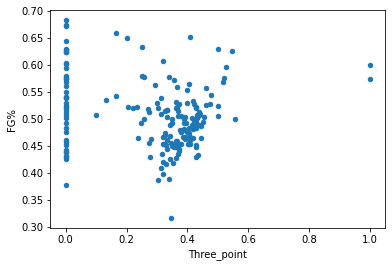

In [0]:
df_pandas.plot.scatter(x='Three_point', y='FG%')  

In [0]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             183 non-null    object 
 1   Team               183 non-null    object 
 2   League             183 non-null    object 
 3   Games_played       183 non-null    int32  
 4   Mins_per_game      183 non-null    float64
 5   Points_per_game    183 non-null    float64
 6   Rebounds_per_game  183 non-null    float64
 7   Assists_per_game   183 non-null    float64
 8   Three_point        183 non-null    float64
 9   FG%                183 non-null    float64
 10  FT%                183 non-null    float64
 11  Steals_per_game    183 non-null    float64
 12  Blocks_per_game    183 non-null    float64
dtypes: float64(9), int32(1), object(3)
memory usage: 18.0+ KB


#### So immediately we can see the impact of the era before the 3 point line. We can address this by excluding all these players for this specific scatter plot. And we can also exclude the outliers with a 100% 3 point shooting average (this will keep the realistic outliers that have over 50% shooting from the 3 point line)

In [0]:
df_pandas_filtered = df_pandas[df_pandas.Three_point > 0.1]
df_pandas_filtered = df_pandas_filtered[df_pandas_filtered.Three_point < 1.0]
display(df_pandas_filtered.head(5))

Player,Team,League,Games_played,Mins_per_game,Points_per_game,Rebounds_per_game,Assists_per_game,Three_point,FG%,FT%,Steals_per_game,Blocks_per_game
Luke Sikma\luke-sikma-1,ALBA Berlin,EuroCup,24,27.0,11.3,6.6,4.2,0.389,0.482,0.769,1.5,0.5
Jan Vesely\jan-vesely-1,Fenerbahce,EuroLeague,31,25.1,12.3,4.7,2.4,0.2,0.651,0.787,1.4,0.5
David Holston\david-holston-1,Dijon,LNB Pro A,33,29.1,14.2,2.5,7.2,0.412,0.464,0.849,1.6,0.0
Drew Crawford\drew-crawford-1,Vanoli Cremona,Lega Serie A,25,31.5,17.8,4.4,2.0,0.37,0.505,0.763,0.8,0.3
Nicolas Laprovittola\nicolas-laprovittola-1,Divina Seguros Joventut,Liga ACB,34,30.6,17.2,2.5,6.4,0.391,0.466,0.792,1.0,0.1


#### And we can redo the scatterplot with this new DF

Out[100]: <AxesSubplot:xlabel='Three_point', ylabel='FG%'>

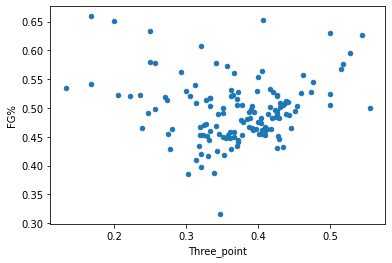

In [0]:
df_pandas_filtered.plot.scatter(x='Three_point', y='FG%')  

#### From this graph we can see a pretty clear trend that good shooters are so regardless of the area on the court. There are some outliers which have remarkable FG%s and very low 3pt percentages. This can be explained by their position (centers and power forwards usually take most of their shots form the paint). Shaquille O'Neal is a great example of a player which fits this outlying statistic.

#### We can now create a more defensive plot, looking at the blocks and rebounds.

Out[101]: <AxesSubplot:xlabel='Rebounds_per_game', ylabel='Blocks_per_game'>

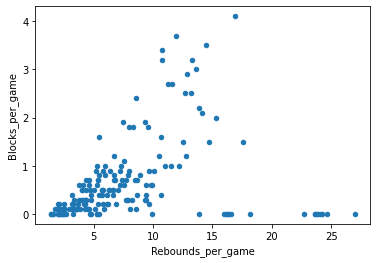

In [0]:
df_pandas.plot.scatter(x='Rebounds_per_game', y='Blocks_per_game')  

#### Here we can find a clear gap in the data set, as there are a lot of players with very high rebounds per game recorded, but no blocks. We can check in the following table that this simply due that there are no record of blocks for these players, that surely excelled at this part of the game.

In [0]:
top_rebounders = spark.sql("SELECT * FROM df_3 ORDER BY Rebounds_per_game desc LIMIT 10")
top_rebounders = top_rebounders.select("Player", "Rebounds_per_game", "Blocks_per_game", "League")
display(top_rebounders)

Player,Rebounds_per_game,Blocks_per_game,League
Wilt Chamberlain\chambwi01,27.0,0.0,NBA
Wilt Chamberlain\chambwi01,24.6,0.0,NBA
Wilt Chamberlain\chambwi01,24.2,0.0,NBA
Bill Russell\russebi01,24.1,0.0,NBA
Bill Russell\russebi01,23.9,0.0,NBA
Wilt Chamberlain\chambwi01,23.8,0.0,NBA
Bill Russell\russebi01,23.6,0.0,NBA
Bill Russell\russebi01,23.6,0.0,NBA
Bill Russell\russebi01,22.7,0.0,NBA
Wes Unseld\unselwe01,18.2,0.0,NBA


#### A good insight that we can extract from this table is that the top rebounders are all from the NBA, which can be explained by the extra 8 mins they get in every game.

# THAT'S IT FOR NOW, THANK YOU FOR READING!!!